# Install Data

In [88]:
# !rm -rf /content/Forehead_Filted.zip
# !rm -rf /content/Forehead_Filted
# !gdown -q 1VqbIYbwpcyitFDH3OJ_mgzyA-tKUZ-ks
# !unzip -q /content/Forehead_Filted.zip


# Install Library

In [89]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from datetime import datetime
from glob import glob
import imageio
from tempfile import TemporaryDirectory
# cudnn.benchmark = True
plt.ion()   # interactive mode

# Preprocessing

In [90]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456,0.406],[0.229,0.224,0.225])
])

In [91]:
batch_size = 64
train_dataset = datasets.ImageFolder(
    '/content/Forehead_Filted/train',
    transform = train_transform
)
test_dataset = datasets.ImageFolder(
    '/content/Forehead_Filted/val',
    transform = test_transform
)

In [92]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle =True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle =False
)

In [93]:
# Class torchvision.datasets.ImageFolder
if hasattr(train_dataset, 'classes'):
    print("Class labels:", train_dataset.classes)
else:
    print("Class labels not found.")

if hasattr(test_dataset, 'classes'):
    print("Class labels:", test_dataset.classes)
else:
    print("Class labels not found.")


Class labels: ['cAverage', 'cFair', 'cGood']
Class labels: ['cAverage', 'cFair', 'cGood']


In [94]:
model = models.mobilenet_v2(pretrained=True)

## In ra kiến trức model mobilev2

In [95]:
# print(model)

In [96]:
# lớp phân loại của mobilenetv2
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [97]:
n_class = 3
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs,num_ftrs),
    nn.Dropout(0.3),
    nn.Linear(num_ftrs,num_ftrs),
    nn.Dropout(0.4),
    nn.Linear(num_ftrs,num_ftrs),
    nn.Dropout(0.7),
    nn.Linear(num_ftrs,n_class)
)

In [98]:
# lớp phân loại sau khi sửa và thêm các lớp cuối
model.classifier

Sequential(
  (0): Linear(in_features=1280, out_features=1280, bias=True)
  (1): Dropout(p=0.3, inplace=False)
  (2): Linear(in_features=1280, out_features=1280, bias=True)
  (3): Dropout(p=0.4, inplace=False)
  (4): Linear(in_features=1280, out_features=1280, bias=True)
  (5): Dropout(p=0.7, inplace=False)
  (6): Linear(in_features=1280, out_features=3, bias=True)
)

In [99]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [100]:
# Loss and optimizer
criteration = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Tạo thư mục chứa weight

In [101]:
folder_path = "output"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f'Thư mục "{folder_path}" đã được tạo.')
else:
    print(f'Thư mục "{folder_path}" đã tồn tại.')


Thư mục "output" đã tồn tại.


# Training

In [102]:
def batch_gd(model, criteration, optimizer, train_loader, test_loader, epoch):
  train_losses = np.zeros(epoch)
  train_accs = np.zeros(epoch)
  test_losses = np.zeros(epoch)
  test_accs = np.zeros(epoch)
  best_acc = 0.0
  best_model_params_path = os.path.join(folder_path, 'MobileNetV2_best.pt')
  last_model_params_path = os.path.join(folder_path, 'MobileNetV2_last.pt')
  for it in range(epoch):
    print(f"Epoch {it+1}/{epoch}")
    print('-' * 10)
    model.train()
    t0 = datetime.now()
    train_loss = []
    n_correct = 0
    n_total = 0
    train_acc = 0
    # Get train_acc and train_loss
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      #forward pass
      outputs = model(inputs)
      loss = criteration(outputs, targets)
      _, predictions = torch.max(outputs, 1)
      # acc
      n_correct += (predictions == targets).sum().item()
      n_total += targets.shape[0]
      # Backward
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    train_acc = n_correct/n_total

    # Save loss and test
    train_losses[it] = train_loss
    train_accs[it] = train_acc

    #Get test loss and test acc
    model.eval()
    test_loss = []
    n_correct = 0
    n_total = 0
    test_acc = 0.0
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criteration(outputs, targets)
      _, predictions = torch.max(outputs, 1)
      # acc
      n_correct += (predictions == targets).sum().item()
      n_total += targets.shape[0]
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)
    test_acc = n_correct/n_total
    # get best accuracy
    if best_acc < test_acc:
      best_acc = test_acc
      torch.save(model.state_dict(), best_model_params_path)
    # Save Loss
    test_losses[it] = test_loss
    test_accs[it] = test_acc

    dt = datetime.now() - t0
    print(f'Train Acc: {train_acc:.4f}, Loss: {train_loss:.4f} \nTest Acc: {test_acc:.4f},Loss:{test_loss:.4f} \nDuration {dt}\n')
    if it == epoch -1:
      print(f"Best Accuracy: {best_acc:.4f}")
      torch.save(model.state_dict(), last_model_params_path)
  return train_losses, test_losses,train_accs,test_accs

In [103]:
epochs = 20
train_losses, test_losses, train_acc, test_acc = batch_gd(
    model,
    criteration,
    optimizer,
    train_loader,
    test_loader,
    epochs
)

Epoch 1/20
----------
Train Acc: 0.3601, Loss: 1.0967 
Test Acc: 0.4162,Loss:1.0644 
Duration 0:00:14.653768

Epoch 2/20
----------
Train Acc: 0.4641, Loss: 1.0513 
Test Acc: 0.5780,Loss:1.0290 
Duration 0:00:14.770135

Epoch 3/20
----------
Train Acc: 0.6076, Loss: 0.9534 
Test Acc: 0.6185,Loss:0.9253 
Duration 0:00:14.695563

Epoch 4/20
----------
Train Acc: 0.6895, Loss: 0.7726 
Test Acc: 0.6590,Loss:0.7669 
Duration 0:00:14.539915

Epoch 5/20
----------
Train Acc: 0.7392, Loss: 0.6097 
Test Acc: 0.6821,Loss:0.6858 
Duration 0:00:14.466629

Epoch 6/20
----------
Train Acc: 0.7888, Loss: 0.5074 
Test Acc: 0.5896,Loss:0.8191 
Duration 0:00:14.373101

Epoch 7/20
----------
Train Acc: 0.7975, Loss: 0.4705 
Test Acc: 0.7803,Loss:0.5535 
Duration 0:00:14.939120

Epoch 8/20
----------
Train Acc: 0.8219, Loss: 0.4168 
Test Acc: 0.7110,Loss:0.5856 
Duration 0:00:14.347952

Epoch 9/20
----------
Train Acc: 0.8416, Loss: 0.3859 
Test Acc: 0.7977,Loss:0.4601 
Duration 0:00:14.496896

Epoch 10/2

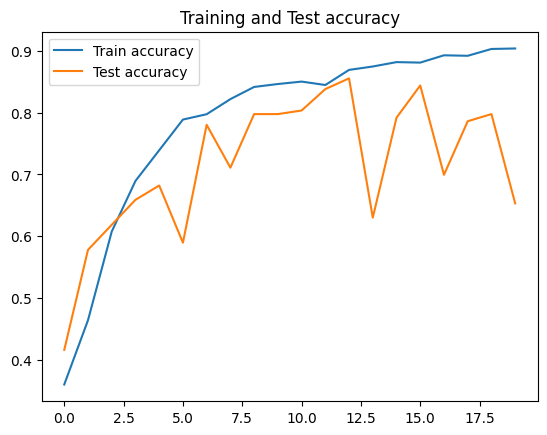

In [104]:
#plot train loss and test loss
plt.plot(train_acc, label="Train accuracy")
plt.plot(test_acc, label="Test accuracy")
plt.title("Training and Test accuracy")
plt.legend()
plt.show()

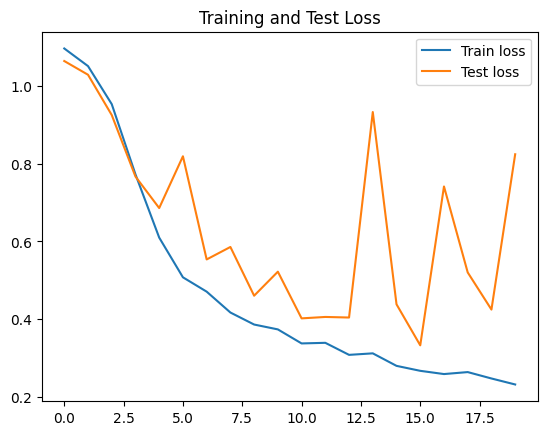

In [105]:
#plot train loss and test loss
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.title("Training and Test Loss")
plt.legend()
plt.show()

In [106]:

n_correct = 0
n_total = 0

for inputs, targets in train_loader:
  #move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs,1)

  # Update count
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total

In [107]:
train_acc

0.7714736012608353

In [108]:
#plot confusion matrix

from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize = False,title = "confusion matrix",cmap = plt.cm.Blues):
  if normalize:
    cm = cm.astype("float")/cm.sum(axis=1)[:,np.newaxis]
    print("Normalize confusion matrix")
  else:
    print("Confusion maxtrix, without normalization")
  print(cm)

  plt.imshow(cm, interpolation = "nearest", cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks,classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2

  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),horizontalalignment="center", color = 'white' if cm[i,j]> thresh else "black")

  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Prediction")
  plt.show()


Confusion maxtrix, without normalization
[[34 17  1]
 [ 3 50  0]
 [38  1 29]]


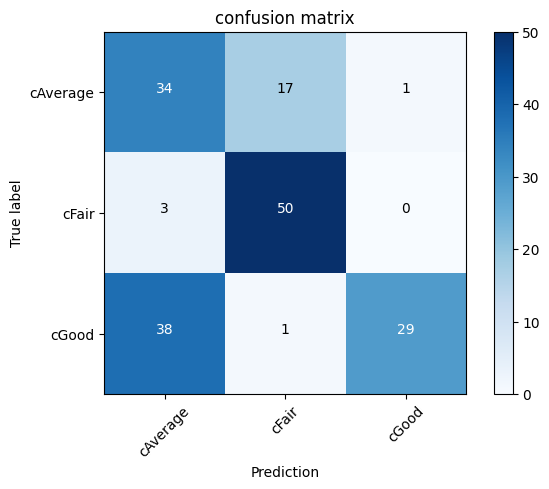

In [109]:
# get all prediction in an array and plot confusion matrix
x_test = test_dataset.imgs
y_test = test_dataset.targets
p_test = np.array([])

for inputs, targets in test_loader:
  inputs = inputs.to(device)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))
cm = confusion_matrix(y_test, p_test)
x = list(train_dataset.classes)
plot_confusion_matrix(cm, x)

# Load best model

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [ ]:
model.load_state_dict(torch.load('/content/output/MobileNetV2_best.pt'))
model.eval()

In [111]:
n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  #move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs,1)

  # Update count
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc_best = n_correct/n_total
print(test_acc_best)

0.8554913294797688
